David Davó Laviña & Ela Katherine Shepherd Arévalo

# Grupo 3, Práctica 2, Parte 2, Apartado A:

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import sklearn
import numpy.ma as ma
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 

![[ -f 'words.txt' ]] || wget https://raw.githubusercontent.com/dwyl/english-words/master/words.txt

with open('words.txt') as f:
    dictionary = f.read().splitlines()

train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')
# El diccionario cargado lo pasamos en el parámetro vocabulary    
cvectorizer = CountVectorizer(vocabulary=dictionary, stop_words='english', binary = False, ngram_range= (1,1))  
cvectorizer.fit_transform(train_data.data)


--2020-05-17 12:28:02--  https://raw.githubusercontent.com/dwyl/english-words/master/words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4863005 (4.6M) [text/plain]
Saving to: ‘words.txt’

words.txt           100%[===================>]   4.64M  17.4MB/s    in 0.3s    

2020-05-17 12:28:03 (17.4 MB/s) - ‘words.txt’ saved [4863005/4863005]



<11314x466551 sparse matrix of type '<class 'numpy.int64'>'
	with 722402 stored elements in Compressed Sparse Row format>

In [ ]:
d = {'data':test_data.data, 'target':test_data.target}
df = pd.DataFrame(data=d)
df.head()

,data,target
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


In [ ]:
# Obtener x mensajes del newsgroup (default 3)
# Por defecto del conjunto de datos de test
def take_msg(ng, n=3, data=test_data):
    if isinstance(ng, str):
        ng = data.target_names.index(ng)
    return [d for target,d in zip(data.target, data.data) if target == ng][:n]

In [ ]:
take_msg("comp.windows.x")

['From: Rick Miller <rick@ee.uwm.edu>\nSubject: X-Face?\nOrganization: Just me.\nLines: 17\nDistribution: world\nNNTP-Posting-Host: 129.89.2.33\nSummary: Go ahead... swamp me.  <EEP!>\n\nI\'m not familiar at all with the format of these "X-Face:" thingies, but\nafter seeing them in some folks\' headers, I\'ve *got* to *see* them (and\nmaybe make one of my own)!\n\nI\'ve got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")\nand I\'ve managed to compile [un]compface too... but now that I\'m *looking*\nfor them, I can\'t seem to find any X-Face:\'s in anyones news headers!  :-(\n\nCould you, would you, please send me your "X-Face:" header?\n\nI *know* I\'ll probably get a little swamped, but I can handle it.\n\n\t...I hope.\n\nRick Miller  <rick@ee.uwm.edu> | <ricxjo@discus.mil.wi.us>   Ricxjo Muelisto\nSend a postcard, get one back! | Enposxtigu bildkarton kaj vi ricevos alion!\n          RICK MILLER // 16203 WOODS // MUSKEGO, WIS. 53150 // USA\n',
 'From: kartik@hls.CO

In [ ]:
"""
Nota: Las dos siguientes funciones no las usamos en exhaust_report porque 
significarían calcular una y otra vez la similiritud del coseno. Aun así,
podemos usarlas para obtener más información sobre una clase o un mensaje
en concreto
"""

def getTopClasses(vectorizer, msg, n=3):
    vd = vectorizer.transform(train_data.data)
    msgv = vectorizer.transform(msg)
    cs = np.argsort(cosine_similarity(msgv, vd), axis=1)[:,::-1]
    return train_data.target[cs[:,:n]]

def getTopClassesNames(vectorizer, msg, n=3):
    return np.array(train_data.target_names)[getTopClasses(vectorizer, msg, n)]

def exhaust_report(vectorizer, nmsgs=3, exhaustivities=[3,10], printoutput=False):
    report = {}
    report["data"] = {x:[] for x in exhaustivities}
    report["labels"] = train_data.target_names
    # Calculamos la distancia del coseno con los datos de entrenamiento
    vector_data = vectorizer.transform(train_data.data)

    for classi, classname in enumerate(train_data.target_names):
        testmsgs = take_msg(classi, nmsgs)
        # Vectorización de los N_MENSAJES mensajes de prueba
        msgvector = vectorizer.transform(testmsgs)
        # Similiritud del coseno de los N_MENSAJES mensajes de prueba
        # ordenados de mayor a menor
        csimil = np.argsort(cosine_similarity(msgvector, vector_data), axis=1)[:, ::-1]

        # Ahora a calcular la precisión de los resultados
        for e in exhaustivities:
            totalp = 0 # Precisión total, para calcular la media
            for imsg, tmsg in enumerate(testmsgs):
                classes = train_data.target[csimil[imsg][:e]] # Top e clases
                p = len(classes[classes==classi])/e # Precisión parcial
                totalp += p
                # print(f"> Class: {classname}, Msg: {imsg}, Exhaustivity: {e}, precission: {p}")
                # print(classes)
                # print(np.array(data.target_names)[classes])
            avgp = totalp/len(testmsgs)
            if printoutput: print(f'Class: {classname.ljust(25)} | exhaustivity: {e:2}, Average precission: {avgp:0.3}')
            report["data"][e].append(avgp)
    
    return report

def plot_exhaust_report(exhaust_report, figsize=(15,4)):
    x = np.arange(len(exhaust_report["labels"]))

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=figsize)

    ax.set_title("Accuracy by newsgroup")
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0,1.2])
    ax.set_xticks(x)

    total_width=.9
    offset_increment = total_width/(len(exhaust_report["data"]))
    offset = 0
    
    for e,p_array in exhaust_report["data"].items():
        pbarcontainer = ax.bar(x+offset, p_array, width=offset_increment, label=f"exhaustivity: {e}")

        for r in pbarcontainer:
            ax.annotate(f'{r.get_height():.2f}'.lstrip('0'),
                xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                xytext=(0,3),
                textcoords="offset points",
                ha="center", va="bottom"
            )
        offset += offset_increment
    
    ax.legend()
    ax.set_xticklabels(exhaust_report["labels"], rotation=45, ha="right")

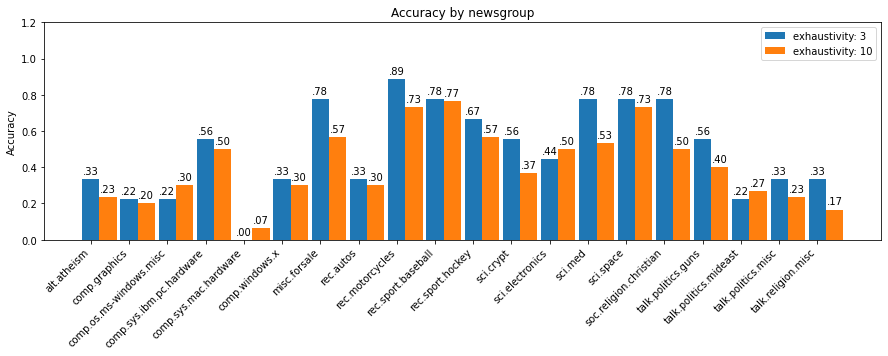

In [ ]:
plot_exhaust_report(exhaust_report(cvectorizer, 3, [3,10], False))

## Conclusiones

La clase `com.sys.mac.hardware` parece ser de las peor clasificadas. En la siguiente celda imprimimos los 3 primeros mensajes, que han tenido un 0% de acierto. En el primero de ellos las clase más relevante parece ser `comp.os.ms-windows.misc`, también un Sistema Operativo. El segundo lo clasifica en `comp.windows.x`, otro sistema operativo. El tercero también tiene windows entre las clases relevantes. Parece saber clasificar en rasgos genéricos la categoria (computadores), pero no la subcategoría. Probablemente se deba a que en informática se utilizan muchos términos y siglas que no están en el diccionario, y que nos ayudarían a diferenciar entre las subcategorías. Por ejemplo, si uno menciona *MSWord* sabremos que se refiere a Windows y si menciona *StyleWriter* probablemente se refiera a un Mac. En el tercero de los mensajes recuperados haría la clasificación muy sencilla, pues las siglas *LCII* muy probablemente se refieran al *Macintosh LC II*, probablemente mencionado múltiples veces en el foro al ser el producto más vendido de Macintosh en 1992¹.

------------------
1. https://tech-insider.org/mac/research/1993/0209-b.html


In [ ]:
msgs = take_msg("comp.sys.mac.hardware")
classes = getTopClassesNames(cvectorizer, msgs, 3)
for msg,c in zip(msgs, classes):
    print(c)
    print(msg)

['comp.os.ms-windows.misc' 'comp.os.ms-windows.misc'
 'comp.os.ms-windows.misc']
From: jacobs@cerritos.edu
Subject: Problem printing Quark on a SWII
Organization: Cerritos College, Norwalk CA
Lines: 15

Iv'e got a problem printing with a StyleWriterII. I am printing from a IIvx
with 20 megs ram. I am trying to print a Quark file that has 2 fonts a couple
of boxes and 3 gradient fills. 

Two things happen: I get a " Disk is full" error, that I can't find documented,
I also have parts of letters that are over one of the gradient fills get cut
off. This only happens to the text over the fill. Text adjecent in a different
box is uneffected.

Any ideas?

Thanks for the help...-- 
_______________________________________________________________________________
Karl Jacobs / jacobs@cerritos.edu ---------------------------------------------
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

['comp.windows.x' 'misc.forsale' 'sci.electronics']
From: s9131783@valiant.

# Grupo 3, Práctica 2, Parte 2, Apartado B:

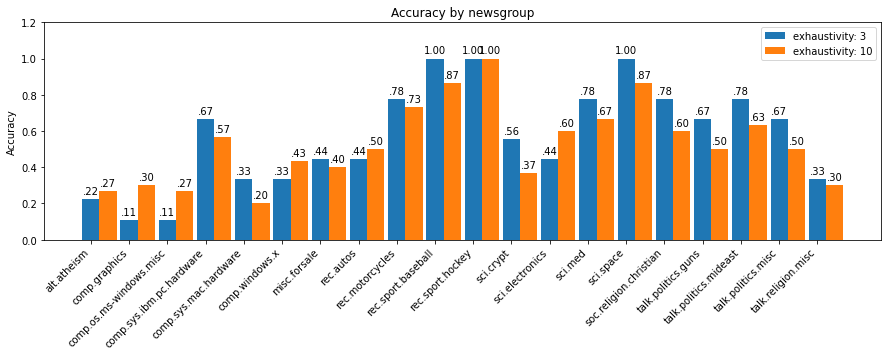

In [ ]:
#Usamos TfidfVectorizer en vez de TfidfTransformer
tfidfvectorizer = TfidfVectorizer(vocabulary=dictionary, stop_words='english', binary=False, ngram_range=(1,1))
tfidfvectorizer.fit(train_data.data)

plot_exhaust_report(exhaust_report(tfidfvectorizer, 3, [3,10]))

##Conclusiones

En comparación con el otro vectorizador, al usar Tfidf los valores de la precisión para las clases son distintos. Estos son los cambios:

   *Resultados con el Tfidf comparado con CountVectorizer* | Nvl ex 3 | Nvl ex 10
--- | --- | ---
alt.atheism | B | S
comp.graphics | B | S
comp.os.ms-windows.misc | B | B
comp.sys.ibm.pc.hardware | S | S
comp.sys.mac.hardware  | S | S
comp.windows.x | - | S
misc.forsale | B | B
rec.autos | S | S
rec.motorcycles | B | -
rec.sport.baseball | S | S
rec.sport.hockey | S | S
sci.crypt | - | -
sci.electronics | - | S
sci.med | - | S
sci.space | S | S
soc.religion.christian | - | S
talk.politics.guns | S | S
talk.politics.mideast | S | S
talk.politics.misc | S | S
talk.religion.misc | - | S


*S = Mejor precisión usando Tfidf*

*B = Peor precisión usando Tfidf*

Parece que, por lo general, aumenta la precisión cuando usamos Tfidf.

Usamos la clase `rec.sport.baseball` para ver la mejora de ciertas clases, tomamos los mismos 3 mensajes y vemos en qué clase se les clasifica con cada vectorizador:

In [ ]:
msgs = take_msg("rec.sport.baseball")
classes = getTopClassesNames(cvectorizer, msgs, 3)
for msg,c in zip(msgs, classes):
    print(c)
    #print(msg) 
    #Descomentar línea superior para ver contenido del mensaje

['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.baseball']
['rec.sport.hockey' 'rec.sport.baseball' 'rec.sport.baseball']
['alt.atheism' 'rec.sport.baseball' 'rec.sport.baseball']


In [ ]:
msgs = take_msg("rec.sport.baseball")
classes = getTopClassesNames(tfidfvectorizer, msgs, 3)
for msg,c in zip(msgs, classes):
    print(c)
    #print(msg)

['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.baseball']
['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.baseball']
['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.baseball']


Como podemos ver, hay mejora al usar Tfidf. Esto puede deberse a que al usar Tfidf hay un mejor filtrado de las _stop words_ para cada clase.